<img src="https://20tree-public.s3-eu-west-1.amazonaws.com/20tree.png" alt="20tree" width="200"/>

# 20tree.ai Candidate Assignment: Cloud Cover Segmentation

- Be sure to set your hardware accelerator to GPU.
- Save a copy of this notebook on github or your drive, or download it as ipynb.
- Don't do your work on this template notebook!
- When you're done upload you final notebook to github, with the trained model uploaded as well.

You should be able to run this at https://colab.research.google.com/. At some point when loading a large tif file it might ask you if you'd like to use a high memory instance, answer "Yes" and things will become even smoother.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import torch
# Make sure a GPU is detected, otherwise go to Edit->Notebook settings->Hardware accelerator->GPU
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

# 1 Cloud Cover Segmentation

We'd like you to create a segmentation model that takes a satellite image as input and segments out the clouds. This is an important aspect of working with satellite data, as cloud-obscured pixels should either be filtered out, or be made aware of through a cloud-mask "band" (in remote sensing, channels are called bands. There are usually more than the usual 3 for rgb in computer vision, eg r,g,b, near infrared, etc)

The dataset we have provided for you consist of satellite tiles from the Sentinel-2 constellation. (see https://sentinel.esa.int/web/sentinel/missions/sentinel-2)

![global grid](https://earth.esa.int/image/image_gallery?uuid=dbd83298-08dd-4992-bb82-11871f1852ac&groupId=247904&t=1371111569215)

Tiles (opr granules) have names such as "58KFC", which are large 100 x 100 km2 images of the earth. For sentinel-2 these come at a resolution of 10m, so an image of about 10980x10980 pixels. A bit larger than your standard computer vision image :D

Usually such satellite "products" have to be preprocessed in variuous ways (atmospheric correction, and all kinds of other denoisong operations). For the purpose of this exercise we will provide you with ready to use tiles.

<img src="https://earth.esa.int/documents/247904/3681412/Sentinel-2-Level-1C-Level-2A-TOA-full.png" alt="processing" width="500"/>

(before and after processing)

# The Data

Sentinel-2 (the data we're using) has 11 bands/channels! For ease here's a snippet that lets you just load the rgb, and near infrared channels. For an overview of all channels see https://en.wikipedia.org/wiki/Sentinel-2.

Since a single image is about 10980 x 10980 pixels, you will want to cut this up into smaller images, before training on them. We'll leave this for you to figure out :)

You will use rasterio, as a library to load a multi band tif file. We have made a couple of tiles available on our public s3.

For example there is the file `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif` which means that its a Sentinel product `2L2A`, a particular enrichment level we don't care much about for the moment. It has been preprocessed usinf `sen2cor`: also not something we care for atm. The tile_id, _is_ something we care for, `58KFC` in this case (No not for Kentucky Fried Chicken), and then the date `2018-20-21`  which is what we care for when there are multiple tiles with the same tile_id, as an image of the earth is unique by `location`  and by `time`. So the tile_id + the date will be the unique identifier. Further we can see that a rough estimation of the percent of clouds is 1.2% and that the Sentinel2 satellite has managed to take an image of the whole area (If there are missing values, they tend to be set to a value of `255`  for `no_data`)

Similarly you can find another tif file called `cloud_mask_58KFC_20181021_clouds=5%.tif`. That's the matching labels we want to learn. They're not perfect as they're automatically created, but they're sufficient for this example. Here we can see that the `tile_id` is the same: `58KFC`, and the date the same as the above input tile as well: `2018-20-21`. The clouds as estimated by an out of the box cloud detection classifier (which should be easy to outperform, even from this rough data you're training on), it estimates that 5% of the image are actually clouds (versus the sentinel2 - similarly not very good - cloud detection model estimates 1.2%).

So there you got it:
- X: `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif`
- Y: `cloud_mask_58KFC_20181021_clouds=5%.tif`

To save space and memory the tiles are also available as RGB only 3-bands (500mb instead of 2.5GB tif files):
- X: `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%_RGB.tif`
- Y: stays the same

example pair stored at a public s3 bucket:
![s3-ex](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/s3-ex.png)

We expect you to figure out the specifics of the data by yourself, but here's a but more info about the cloud mask which we derived from the [theia-sentinel product](https://labo.obs-mip.fr/multitemp/sentinel-2/theias-sentinel-2-l2a-product-format/#English):

<img src="https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/theia_cloud_mask.png" alt="theia_cm" width="400"/>


Example pairs of tile and mask:
![ex1](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex1.png)
![ex2](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex2.png)
![ex3](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex3.png)


To make things easier we've hosted 3 text files with links to all the data, allowing you to more easily download all files:
- rgb_tiles.txt: https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/rgb_tiles.txt
- tif_tiles.txt: https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/tif_tiles.txt
- masks.txt: https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt

In [0]:
!wget --content-disposition --trust-server-names -i https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt
!wget --content-disposition --trust-server-names -i https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/tif_tiles.txt

--2020-04-28 13:07:23--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt
Resolving 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)... 52.218.101.72
Connecting to 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)|52.218.101.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1378 (1.3K) [text/plain]
Saving to: ‘masks.txt’

masks.txt           100%[===================>]   1.35K  --.-KB/s    in 0s      

2020-04-28 13:07:24 (86.8 MB/s) - ‘masks.txt’ saved [1378/1378]

--2020-04-28 13:07:24--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/cloud_mask_18TUR_20180812_clouds%3D24%25.tif
Reusing existing connection to 20tree-public.s3-eu-west-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1830454 (1.7M) [image/tiff]
Saving to: ‘cloud_mask_18TUR_20180812_clouds=24%.tif’

cloud_mask_18TUR_20 100%[===================>]  

In [0]:
!ls -lah *.tif


-rw-r--r-- 1 root root 1.8M Apr 16 10:36 'cloud_mask_18TUR_20180812_clouds=24%.tif'
-rw-r--r-- 1 root root 2.6M Apr 16 10:42 'cloud_mask_21NYC_20171206_clouds=84%.tif'
-rw-r--r-- 1 root root 3.4M Apr 16 10:45 'cloud_mask_28PDU_20171002_clouds=70%.tif'
-rw-r--r-- 1 root root 974K Apr 16 10:44 'cloud_mask_28PDU_20180609_clouds=16%.tif'
-rw-r--r-- 1 root root 2.0M Apr 16 10:43 'cloud_mask_29RPP_20180206_clouds=44%.tif'
-rw-r--r-- 1 root root 1.9M Apr 16 10:39 'cloud_mask_30TXR_20190618_clouds=35%.tif'
-rw-r--r-- 1 root root 1.6M Apr 16 10:41 'cloud_mask_31PDM_20190911_clouds=79%.tif'
-rw-r--r-- 1 root root 1.4M Apr 16 10:37 'cloud_mask_31TCG_20171030_clouds=40%.tif'
-rw-r--r-- 1 root root 1.2M Apr 16 10:40 'cloud_mask_32SNC_20181202_clouds=21%.tif'
-rw-r--r-- 1 root root 2.7M Apr 16 10:38 'cloud_mask_33TVF_20191104_clouds=84%.tif'
-rw-r--r-- 1 root root 2.8M Apr 16 10:43 'cloud_mask_49RFN_20190806_clouds=61%.tif'
-rw-r--r-- 1 root root 715K Apr 16 10:39 'cloud_mask_58KFC_20181021_clouds=5

I'll leave the rest for you to download

You can download the s3 data to use here, but since they're pretty large you can also upload the dataset to your google drive where you can use it by mounting it like here:

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


Since all of this might be a bit new and we dont expect you to spend more than 1-2 days part-time, we will provide some helper functions for using geotif data through rasterio:

In [0]:
!pip install rasterio

     |████████████████████████████████| 18.1MB 198kB/s 


In [0]:
from matplotlib import pyplot as plt
import os
import rasterio
import numpy as np

def _ensure_opened(ds):
    "Ensure that `ds` is an opened Rasterio dataset and not a str/pathlike object."
    return ds if type(ds) == rasterio.io.DatasetReader else rasterio.open(str(ds), "r")


def read_crop(ds, crop, bands=None, pad=False):
    """
    Read rasterio `crop` for the given `bands`..
    Args:
        ds: Rasterio dataset.
        crop: Tuple or list containing the area to be cropped (px, py, w, h).
        bands: List of `bands` to read from the dataset.
    Returns:
        A numpy array containing the read image `crop` (bands * h * w).
    """
    ds = _ensure_opened(ds)
    if pad: raise ValueError('padding not implemented yet.')
    if bands is None:
        bands = [i for i in range(1, ds.count+1)]

    #assert len(bands) <= ds.count, "`bands` cannot contain more bands than the number of bands in the dataset."
    #assert max(bands) <= ds.count, "The maximum value in `bands` should be smaller or equal to the band count."
    window = None
    if crop is not None:
        assert len(crop) == 4, "`crop` should be a tuple or list of shape (px, py, w, h)."
        px, py, w, h = crop
        w = ds.width - px if (px + w) > ds.width else w
        h = ds.height - py if (py + h) > ds.height else h
        assert (px + w) <= ds.width, "The crop (px + w) is larger than the dataset width."
        assert (py + h) <= ds.height, "The crop (py + h) is larger than the dataset height."
        window = rasterio.windows.Window(px, py, w, h)
    meta = ds.meta
    meta.update(count=len(bands))
    if crop is not None:
        meta.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, ds.transform)})
    return ds.read(bands, window=window), meta

def plot_rgb(img, clip_percentile=(2, 98), clip_values=None, bands=[3, 2, 1], figsize=(20, 20), nodata=None, figtitle=None, crop=None, ax=None):
    """
    Plot clipped (and optionally cropped) RGB image.
    Args:
        img: Path to image, rasterio dataset or numpy array of shape (bands, height, width).
        clip_percentile: (min percentile, max percentile) to use for clippping.
        clip_values: (min value, max value) to use for clipping (if set clip_percentile is ignored).
        bands: Bands to use as RGB values (starting at 1).
        figsize: Size of the matplotlib figure.
        figtitle: Title to use for the figure (if None and img is a path we will use the image filename).
        crop: Window to use to crop the image (px, py, w, h).
        ax: If not None, use this Matplotlib axis for plotting.
    Returns:
        A matplotlib figure.
    """
    meta = None
    if isinstance(img, str):
        assert os.path.exists(img), "{} does not exist!".format(img)
        figtitle = os.path.basename(img) if figtitle is None else figtitle
        img = rasterio.open(img)
        img, meta = read_crop(img, crop, bands)
    elif isinstance(img, rasterio.io.DatasetReader):
        img, meta = read_crop(img, crop, bands)
    elif isinstance(img, np.ndarray):
        assert len(img.shape) <= 3, "Array should have no more than 3 dimensions."
        if len(img.shape) == 2:
            img = img[np.newaxis, :, :]
        elif img.shape[0] > 3:
            img = img[np.array(bands) - 1, :, :]
        if crop is not None:
            img = img[:, py:py+h, px:px+w]
    else:
        raise ValueError("img should be str, rasterio dataset or numpy array. (got {})".format(type(img)))
    img = img.astype(float)
    nodata = nodata if nodata is not None else (meta['nodata'] if meta is not None else None)
    if nodata is not None:
        img[img == nodata] = np.nan
    if clip_values is not None:
        assert len(clip_values) == 2, "Clip values should have the shape (min value, max value)"
        assert clip_values[0] < clip_values[1], "clip_values[0] should be smaller than clip_values[1]"
    elif clip_percentile is not None:
        assert len(clip_percentile) == 2, "Clip_percentile should have the shape (min percentile, max percentile)"
        assert clip_percentile[0] < clip_percentile[1], "clip_percentile[0] should be smaller than clip_percentile[1]"
        clip_values = None if clip_percentile == (0, 100) else [np.nanpercentile(img, clip_percentile[i]) for i in range(2)]
    if clip_values is not None:
        img[~np.isnan(img)] = np.clip(img[~np.isnan(img)], *clip_values)
    clip_values = (np.nanmin(img), np.nanmax(img)) if clip_values is None else clip_values
    img[~np.isnan(img)] = (img[~np.isnan(img)] - clip_values[0])/(clip_values[1] - clip_values[0])
    if img.shape[0] <= 3:
        img = np.transpose(img, (1, 2, 0))
    alpha = np.all(~np.isnan(img), axis=2)[:,:,np.newaxis].astype(float)
    img = np.concatenate((img, alpha), axis=2)

    if not ax:
        figure, ax = plt.subplots(1, 1, figsize=figsize)
        ax.set_title(figtitle) if figtitle is not None else None
        ax.imshow(img)
        plt.close()
        return figure
    else:
        ax.imshow(img)

Time to check the data for real:

In [0]:
X = ["Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif"]
y = ["cloud_mask_58KFC_20181021_clouds=5%.tif"]

Lets plot the full tile, but rescaled to a managable size with our plot_rgb() function, as well as choosing with bands to visualize as rgb (1-3 in this example), as a matplotlib figure, so we dont blow things up:

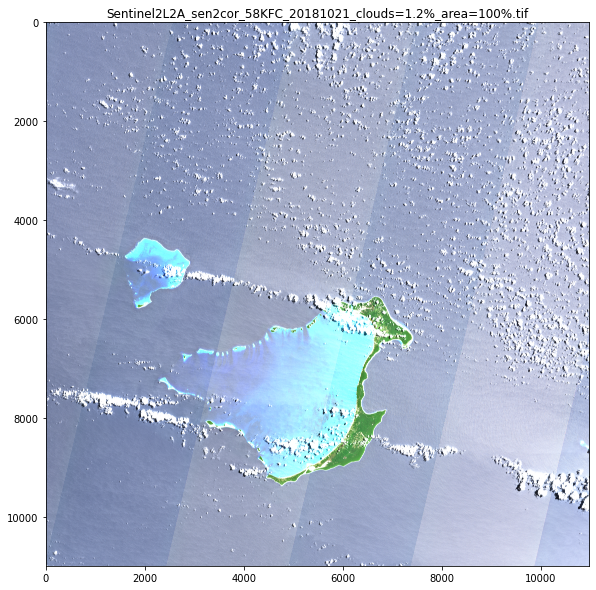

In [0]:
plot_rgb(X[0], clip_values=(0,1000), bands=[3,2,1], figsize=(10, 10))

same for the cloud mask that only has 1 band/channel, so we put band 1 for r,g _and_ b :) :

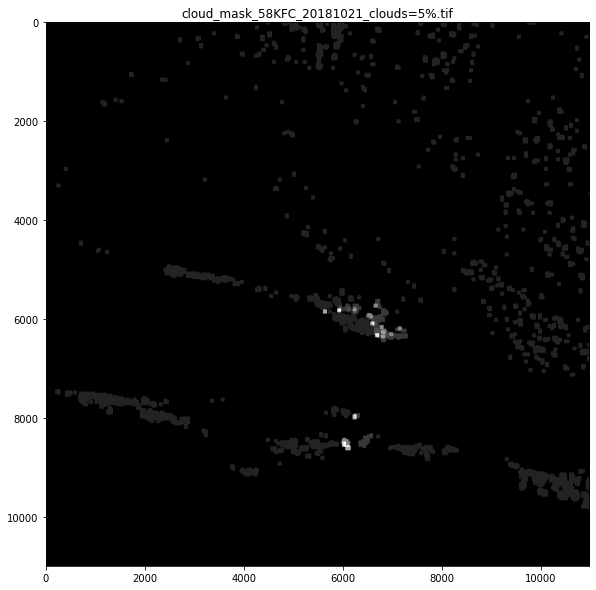

In [0]:
plot_rgb(y[0], clip_values=(0,50), bands=[1,1,1], figsize=(10, 10))

To make things a little bit easier, as rasterio specifics might be unfamiliar, heres an example of that reads a particular patch of a larger window:


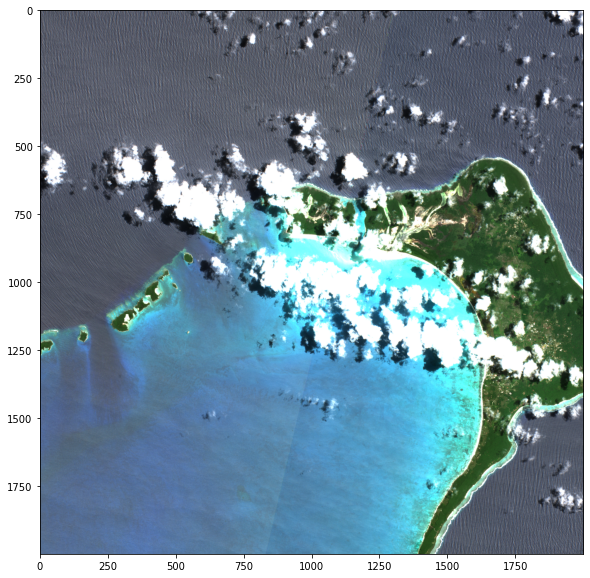

In [0]:
bands=[3,2,1]
ds = _ensure_opened(X[0])
(px, py, w, h) = 5000,5000,2000,2000 #left, top, tilesize, tilesize
image, meta = read_crop(ds, (px, py, w, h), bands=bands)

#write it away as a file
with rasterio.open("testX.tif", 'w', **meta) as dst:
    dst.write(image)

#show it
fig = plt.figure(figsize=(10,10))
img = rasterio.open("testX.tif").read()
img = np.clip(img, 0, 2000)/2000.0
plt.imshow(np.transpose(img, (1,2,0)))

In [0]:
image.shape

(3, 2000, 2000)

3 channels/bands, reading the actual tif directly through rasterio will give us the full data to work with:

In [0]:
im = rasterio.open(X[0]).read(8) #here we read band 8, which you can see in the sentinel product documentation is the NIR band
im.shape

IndexError: ignored

In [0]:
img = im[:1000,:1000].reshape((1,1000,1000)) #lets visualize a 1000px x 1000px window

In [0]:
fig = plt.figure(figsize=(10,10))
img = np.clip(img, 0, 1000)/1000.0
plt.imshow(np.transpose(np.repeat(img, [3], axis=0),(1,2,0))) #simple hack to show 1 channel as 3, we just copy it 3 times :)

Let's visualize the cloud mask:

In [0]:
bands=[1] # only 1 channel/band
ds = _ensure_opened(y[0])
(px, py, w, h) = 5000,5000,2000,2000 #left, top, right-left, bottom-top
image, meta = read_crop(ds, (px, py, w, h), bands=bands)

#write it away as a file
with rasterio.open("testY.tif", 'w', **meta) as dst:
    dst.write(image)

#show it
fig = plt.figure(figsize=(10,10))
img = rasterio.open("testY.tif").read()
img = np.clip(img, 0, 50)/50.0 # we put max to 50 here but this is image specific
plt.imshow(np.transpose(np.repeat(img, [3], axis=0),(1,2,0))) #simple hack to show 1 channel as 3, we just copy it 3 times :)

We can also check all unique values in the cloud mask, remembering that particular bits are used for particular values (go back to the theia sentinel product image to see their meaning)

In [0]:
image.shape

In [0]:
np.unique(image)

# What we expect from you

- Train a segmentation model that correctly segments out clouds.
- You have to use [PyTorch](https://pytorch.org/) (helper libraries as [fastai](https://fast.ai) are fine to use, but be sure to use [v2](https://github.com/fastai/fastai2/) in this case)
- You can start out using the `_RGB.tif` tiles but for the final model we want to see you're able to evaluate different bands, and train a model that works with more than 3 channels.
- When you're done upload the final notebook to github as well as the final trained model so we can run your prediction code with it.
- Its not as important to have an amazingly great model: there's not enough data to make this great, but we do want to see how you go about solving this problem, the steps you took to make sense of the data, and how you evaluate your model performance.

## some advise:
- you will want to split up the larger tiles into smaller batches of much smaller pixels (64-256px) for easier and more generalizable training
- you might want to use data augmentation to "synthetize" more training data
- Google Earth Engine lets you play with datasets for satellite imagery in a javascript playground. If satellite images are new to you, you might want to have a go here as well to see whats generally possible. Do note that all examples here are more classical remote sensing, and no deep learning approaches, which is what 20tree.ai specializes in and what we want to see from you. https://developers.google.com/earth-engine/playground & https://code.earthengine.google.com/
- for easy starting out you could consider resizing the image to a smaller size first and get everything working first, after which you can try the real stuff. - You can also start using the _RGB tif files first.

## More data:
- you are allowed to add more data by downloading Sentinel tiles, or adding other cloud cover datasets.
- The tiles we have made available for you are L2A (sen2cor processed) products that will be missing some atmospheric bands that _are_ available in the L2A products. If you feel like going the extra mile you _could_  download these from https://scihub.copernicus.eu/. There's a short tutorial [here](https://www.gis-blog.com/download-sentinel-2-l2a-products/).

## Bonus points
- a model that generalizes well towards unseen examples is what we are looking for, and is generally the whole purpose of ML models in industry. We _will_  test your model on some out-of-dataset tiles
- some idea about existing research and using some of those learnings, eg using arxiv-sanity one can find a bunch of deep learning based cloud cover segmentation or removal papers: http://www.arxiv-sanity.com/search?q=+cloud+cover+satellite

---

# ML TIME! 

In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Implementation is stolen from github (https://github.com/milesial/Pytorch-UNet)
# However I made it a bit smaller
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
       

In [0]:
from pathlib import Path
import numpy as np

def create_split_train_and_test(data_folder, ratio=0.8):
  np.random.seed(42)
  images, labels = [], []
  for file in data_folder.iterdir():
    if "Sentinel" in file.name:
      images.append(file)
    elif "cloud_mask" in file.name:
      labels.append(file)
  images, labels = list(sorted(images)), list(sorted(labels))
  assert len(labels) == len(images)
  ratio_integer = int(np.ceil(0.8 * len(images)))
  train_samples = np.random.choice(len(images), size=ratio_integer, replace=False)
  training_data = [(images[idx], labels[idx]) for idx in train_samples]
  validation_data = [(images[idx], labels[idx]) for idx in range(len(images)) if idx not in train_samples]
  return training_data, validation_data


In [0]:
data_path = Path("./")
training_data, test_data = create_split_train_and_test(data_path)

In [0]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
import pickle

class Satelite_Dataset(Dataset):
  def __init__(self, dataset, crop_size, device, split="train", original_image_size=10980):
    self.split = split
    self.device = device
    self.crop_size = crop_size
    self.original_image_size = original_image_size
    self.dataset = dataset

  def __getitem__(self, i):
    image_path, label_path = self.dataset[i]
    image, label = self.joint_transform_train(image_path, label_path)
    label = torch.from_numpy(np.array(label, dtype=np.int32)).float()
    label = (label > 0).long()
    return image.to(self.device), label.to(self.device)
  
  def __len__(self):
    return len(self.dataset)

  def joint_transform_train(self, image_path, mask_path):
    left_top = np.random.randint(0, self.original_image_size - self.crop_size, size=2)
    image, _ = read_crop(image_path, (left_top[0], left_top[1], self.crop_size, self.crop_size))
    mask, _ = read_crop(mask_path, (left_top[0], left_top[1], self.crop_size, self.crop_size))
    image = np.transpose(image, (1, 2, 0))
    image = np.clip(image, 0, 2000)
    image = (image - np.amin(image))/(np.amax(image) - np.amin(image)) * 255 # Normalize image
    channels = image.shape[2]
    final_image = []
    mask = Image.fromarray(mask.squeeze().astype(np.uint8))
    angle = np.random.randint(-180, 180)
    flip = np.random.uniform() > 0.5
    if flip:
      mask = TF.hflip(mask)
    mask = mask.rotate(angle)
    for i in range(channels):
      channel = image[:, :, i].squeeze()
      channel = Image.fromarray(channel.astype(np.uint8))
      if flip:
        channel = TF.hflip(channel)
      channel = channel.rotate(angle) # pytorch rotate is broken..
      channel = TF.to_tensor(channel)
      final_image.append(channel)
    image = torch.stack(final_image).squeeze()
    return image, mask


In [0]:
def save_checkpoint(epoch, model, optimizer, output_folder):
    state = {'epoch': epoch + 1,
             'model': model,
             'optimizer': optimizer}
    torch.save(state, output_folder / 'cloud_segmentation.pth')

def store_intermediate_result(image, prediction, label, output_folder, epoch):
  image, prediction, label = image[0][:3].cpu().numpy(), prediction[0].detach().cpu(), label[0].cpu().numpy()
  prediction = torch.sigmoid(prediction.squeeze()).numpy()
  output_folder = output_folder / "images"
  output_folder.mkdir(exist_ok=True, parents=True)

  fig = plt.figure(figsize=(10,10))
  plt.imshow(prediction, vmin=0, vmax=1)
  plt.savefig(output_folder / f"{epoch}_prediction.png")
  plt.close()

  fig = plt.figure(figsize=(10,10))
  plt.imshow(label.squeeze(), vmin=0, vmax=1)
  plt.savefig(output_folder / f"{epoch}_label.png")
  plt.close()

  fig = plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.savefig(output_folder / f"{epoch}_input.png")
  plt.close()

def train_model(train_data, expiment_path, crop_size, input_channels, batch_size, 
                learning_rate, training_epochs, print_save_freq, class_weighting):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  experiment_path.mkdir(exist_ok=True)
  train_set = Satelite_Dataset(train_data, crop_size, device)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                             shuffle=True, num_workers=0)
  model = UNet(input_channels, 1).to(device)
  cloud_weight = torch.FloatTensor([class_weighting]).to(device)
  optimizer = torch.optim.Adam(model.parameters(), learning_rate)
  loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=cloud_weight)
  for epoch in range(training_epochs):
    mean_loss_epoch = []
    for iteration, (image, label) in enumerate(train_loader):
      prediction = model(image)
      loss = loss_function(prediction.squeeze(), label.type_as(prediction))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      mean_loss_epoch.append(loss.item())
    if epoch % print_save_freq == 0:
      print(f"{epoch}/{training_epochs}: mean loss of epoch: {np.mean(mean_loss_epoch)} ")
      store_intermediate_result(image, prediction, label, experiment_path, epoch)
      save_checkpoint(epoch, model, optimizer, experiment_path)


In [0]:
input_channels = 11
crop_size = 610
batch_size = 5
learning_rate = 0.003
training_epochs = 200
print_save_freq = 10
class_weighting = 1.
experiment_path = Path("/gdrive/My Drive/20tree/")
train_model(training_data, 
            experiment_path, 
            crop_size, 
            input_channels, 
            batch_size, 
            learning_rate,
            training_epochs,
            print_save_freq,
            class_weighting)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


0/200: mean loss of epoch: 0.6619590222835541 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DoubleConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Down. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Up. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packag

10/200: mean loss of epoch: 0.48830990493297577 
20/200: mean loss of epoch: 0.4568363130092621 
30/200: mean loss of epoch: 0.4620925635099411 
40/200: mean loss of epoch: 0.5170592218637466 
50/200: mean loss of epoch: 0.6072297692298889 
60/200: mean loss of epoch: 0.39586347341537476 
70/200: mean loss of epoch: 0.3724091053009033 
80/200: mean loss of epoch: 0.3843902349472046 
90/200: mean loss of epoch: 0.39043374359607697 
100/200: mean loss of epoch: 0.4188571870326996 
110/200: mean loss of epoch: 0.35980184376239777 
120/200: mean loss of epoch: 0.43567974865436554 
130/200: mean loss of epoch: 0.416791208088398 
140/200: mean loss of epoch: 0.3324924409389496 
150/200: mean loss of epoch: 0.4342001676559448 
160/200: mean loss of epoch: 0.4582003355026245 
170/200: mean loss of epoch: 0.4127380847930908 
180/200: mean loss of epoch: 0.4754951000213623 
190/200: mean loss of epoch: 0.49098095297813416 


In [0]:
def evaluate(predictions, gts):
    acc = (predictions == gts).sum()/np.prod(predictions.shape)
    true_pos = ((predictions == 1) * (gts == 1)).sum()
    true_neg = ((predictions == 0) * (gts == 0)).sum()
    false_pos = ((predictions == 1) * (gts == 0)).sum()
    false_neg = ((predictions == 0) * (gts == 1)).sum()
    total = np.prod(predictions.shape)
    print(f"true positives / false positives: {true_pos/total}/{false_pos/total}")
    print(f"true negatives / false negatives: {true_neg/total}/{false_neg/total}")
    assert(sum([true_pos, true_neg, false_pos, false_neg]) == np.prod(predictions.shape))
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f_score = 2 * ((precision * recall)/(precision + recall))
    return acc, precision, recall, f_score

def in_order_crop_creator(image, crop_size, device, mask=None, image_size=10980):
  assert(image_size % crop_size == 0)
  number_of_crops_per_dimension = int(image_size/crop_size)
  for i in range(number_of_crops_per_dimension):
    for j in range(number_of_crops_per_dimension):
      image_crop, _ = read_crop(image, (i * crop_size, j * crop_size, crop_size, crop_size))
      if mask:
        mask_crop, _ = read_crop(mask, (i * crop_size, j * crop_size, crop_size, crop_size))
      image_crop = np.clip(image_crop, 0 , 2000)
      image_crop = np.transpose(image_crop, (1, 2, 0))
      channels = image_crop.shape[2]
      image_crop = (image_crop - np.amin(image_crop))/(np.amax(image_crop) -  np.amin(image_crop)) * 255
      final_image = []
      for k in range(channels):
        channel = image_crop[:, :, k]
        channel = TF.to_tensor(Image.fromarray(channel.astype(np.uint8)))
        final_image.append(channel)
      image_crop = torch.stack(final_image).squeeze()
      if mask:
        mask_crop = Image.fromarray(mask_crop.squeeze().astype(np.uint8))
        mask_crop = torch.from_numpy(np.array(mask_crop, dtype=np.int32)).float()
        mask_crop = (mask_crop > 0).long()
        yield image_crop.unsqueeze(dim=0), mask_crop.unsqueeze(dim=0)
      else:
        yield image_crop.unsqueeze(dim=0)

def run_inference(test_data, crop_size, exp_path, model_name):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  checkpoint = torch.load(exp_path / model_name)
  model = checkpoint['model']
  output_folder = exp_path / "inference"
  output_folder.mkdir(exist_ok=True)
  predictions = []
  labels = []
  counter = 1
  for iteration, (image, label) in enumerate(test_data):
    for crop_image, crop_mask in in_order_crop_creator(image, crop_size, device, mask=label):
      with torch.no_grad():
        prediction = model(crop_image.to(device))
      store_intermediate_result(crop_image, prediction, crop_mask, exp_path, counter)
      predictions.append((torch.sigmoid(prediction.detach().cpu()).squeeze() > 0.5).long())
      labels.append((crop_mask.cpu().squeeze()))
      counter += 1
  acc, precision, recall, f_score = evaluate(torch.stack(predictions).numpy(), torch.stack(labels).numpy())
  print(f"Accuracy: {acc}")
  print(f"Precision/recall: {precision}/{recall}")
  print(f"F-score: {f_score}")

In [0]:
crop_size = 610
model_name = "cloud_segmentation.pth"
exp_path = Path("/gdrive/My Drive/20tree/")
random_samples = np.random.choice(len(training_data), size=2, replace=False)
run_inference([training_data[i] for i in random_samples], crop_size, exp_path, model_name)

true positives / false positives: 0.2561521776636441/0.13119450914230543
true negatives / false negatives: 0.3453168577741945/0.26733645541985596
Accuracy: 0.6014690354378386
Precision/recall: 0.6612995189809628/0.48931755433701285
F-score: 0.5624555220250659


In [0]:
# Test data is just a list of tuples with the input and label paths
run_inference(test_data, crop_size, exp_path, model_name)

true positives / false positives: 0.20936516053364124/0.16531484218698678
true negatives / false negatives: 0.3592296848716494/0.26609031240772263
Accuracy: 0.5685948454052906
Precision/recall: 0.5587839196471603/0.44034651497104854
F-score: 0.4925454037090046


In [0]:
def run_prediction(image_path, model, crop_size):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  checkpoint = torch.load(model)
  model = checkpoint["model"]
  predictions = []
  for image_crop in in_order_crop_creator(image_path, crop_size, device):
    with torch.no_grad():
      prediction = model(image_crop.to(device))
    predictions.append((prediction.squeeze().cpu() > 0.5).long())
  complete_img = create_single_image_from_crops(predictions, crop_size)
  return np.expand_dims(complete_img.squeeze().numpy(), axis=2)

def create_single_image_from_crops(crop_predictions, crop_size, image_size=10980):
  assert(image_size % crop_size == 0)
  crop_per_dimension = int(image_size / crop_size)
  vertical_pieces = [torch.cat(crop_predictions[i * crop_per_dimension:(i * crop_per_dimension) + crop_per_dimension], dim=0)
   for i in range(crop_per_dimension)]
  complete_image = torch.cat(vertical_pieces, dim=1)
  return complete_image



In [0]:
model_name = "cloud_segmentation.pth"
exp_path = Path("/gdrive/My Drive/20tree/")
model = exp_path / model_name
crop_size = 610
image_path, label_path = test_data[0]
print(f"File name: {image_path}")
# prediction = run_prediction(image_path, model, crop_size)

File name: Sentinel2L2A_sen2cor_28PDU_20180609_clouds=0.5%_area=99%.tif


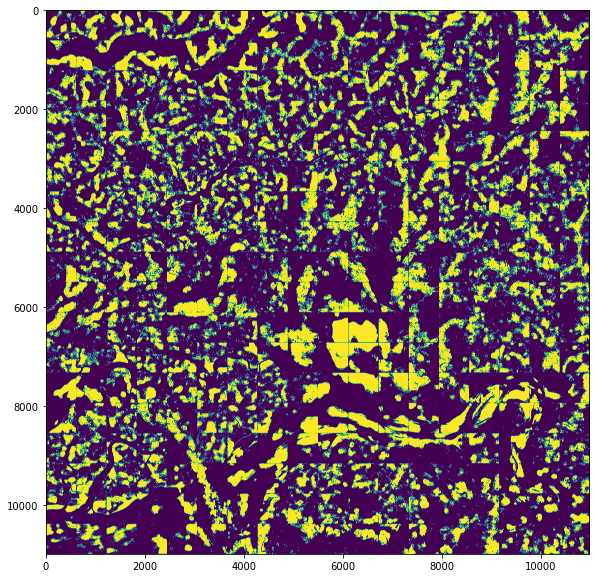

In [0]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(prediction.squeeze(), vmin=0, vmax=1)
plt.show()

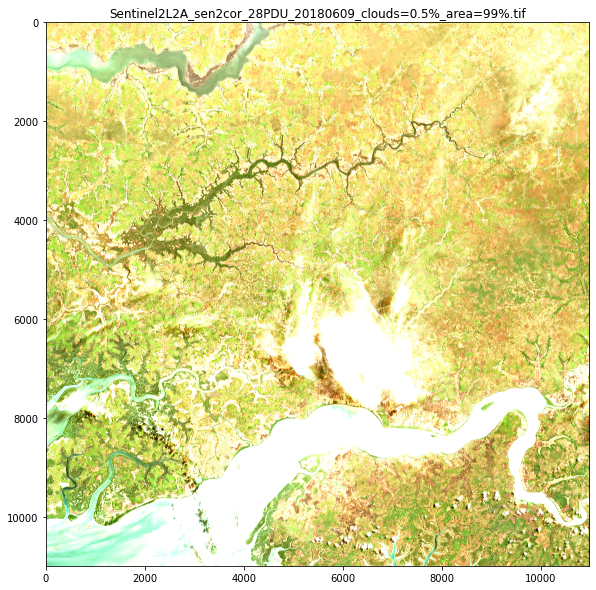

In [0]:
plot_rgb(image_path.name, clip_values=(0,1000), bands=[3,2,1], figsize=(10, 10))

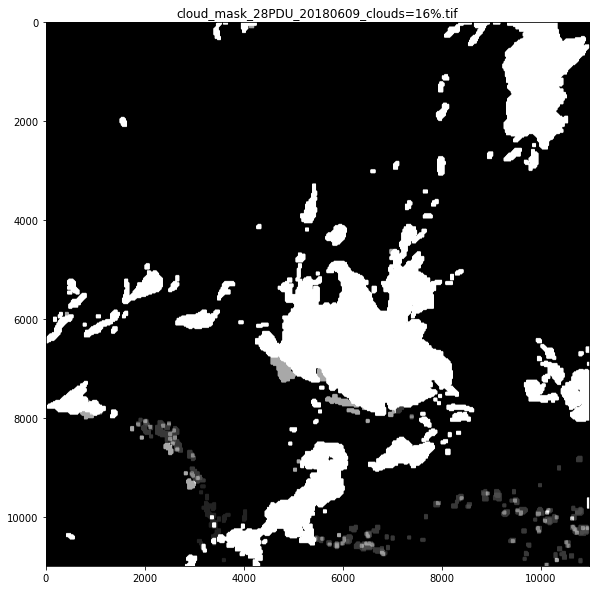

In [0]:
plot_rgb(label_path.name, clip_values=(0,50), bands=[1,1,1], figsize=(10, 10))

---

# Why we're doing this?

There's a couple of blog post that explain a bit more about what we're working on with 20tree.ai, and why we believe that satellite imagery + domain knowledge and experts on the ground + Artificial Intelligence have the potential to make a _real_  impact on climate change, deforestation and forest fires:

- fighting deforestation Evergreen treewith AI: https://medium.com/20tree-ai/how-can-machine-learning-help-to-feed-9-8-billion-people-in-2050-d4ea9dea28a6
- supporting efforts against forest fires Fire: https://medium.com/20tree-ai/wildfires-on-the-rise-d586c990af30
- helping to understand urban green environments: https://medium.com/20tree-ai/quantifying-greenness-of-cities-with-satellite-imagery-and-ai-be5117ef5d75
- in-depth interview with one of our data-scientists, Rochelle: https://medium.com/@jessertel/20tree-ai-6d1879ba72f7
- what we're building to help large electric utilities to prevent forest fires (responsible for > 1% of global co2 emissions!): http://www.20tree.ai/vegetation-management/



Good luck!

<img src="https://20tree-public.s3-eu-west-1.amazonaws.com/20treeAI+-+Team+picture.jpg" alt="team" width="500"/>
